In [1]:
import stan

import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [2]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az # For visualization and loo
import seaborn as sns 

# Using Stan to fit a binomial model

In [12]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'normal.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// Stan code to fit normal distribution with improper prior

data {
  int<lower=0> N;
  real y[N];
}
parameters {
  real mu;
  real sigma;

}
model {
    y ~ normal(mu, sigma);
    // alternative way to write the above line
    // target += normal_lpdf(y | mu, sigma);
}



In [13]:
true_mu = .3
true_sigma = .1

In [14]:
N = 1000
y = np.random.normal(true_mu, true_sigma, N)
stan_data = {'N': N, 'y': y} 

In [15]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...

In file included from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include


Building: 16.4s, done.Messages from stanc:
Warning in '/tmp/httpstan_vnhmlj6k/model_soxmsrwt.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_vnhmlj6k/model_soxmsrwt.stan', line 13, column 19: A
    normal distribution is given parameter sigma as a scale parameter
    (argument 2), but sigma was not constrained to be strictly positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [16]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)


Sampling:   0%
Sampling:  50% (1200/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is -1.43456, but must be positive! (in '/tmp/httpstan_cpwg_3bo/model_soxmsrwt.stan', line 13, column 4 to column 26)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is -0.0726846, but must be p

In [17]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model)

In [18]:
summary = az.summary(fit)

In [19]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.300,0.003,0.294,0.306,0.0,0.0,953.0,1162.0,1.0
sigma,0.098,0.002,0.094,0.102,0.0,0.0,1868.0,1336.0,1.0


array([<AxesSubplot: title={'center': 'mu'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

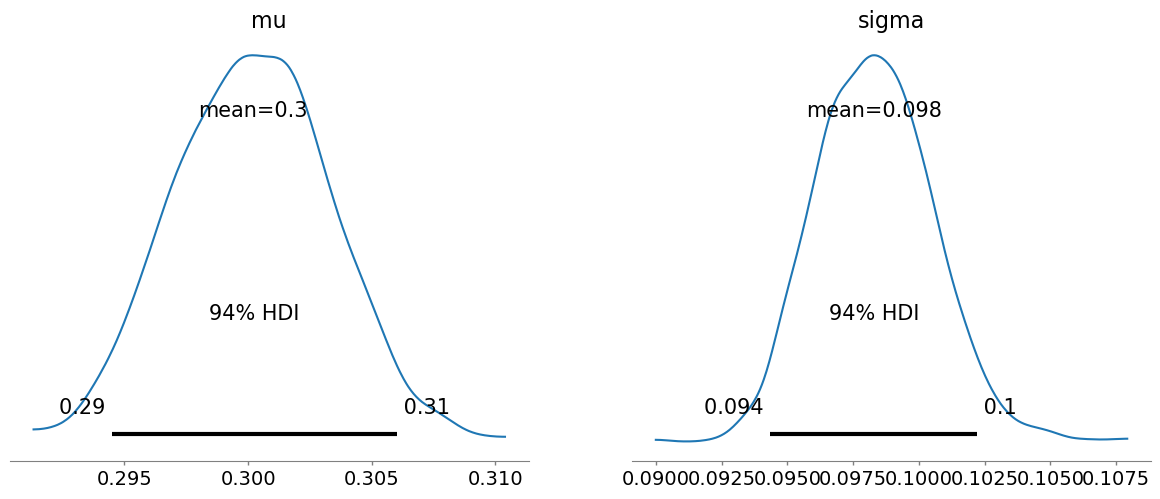

In [20]:
az.plot_posterior(idata)

<AxesSubplot: xlabel='mu', ylabel='Count'>

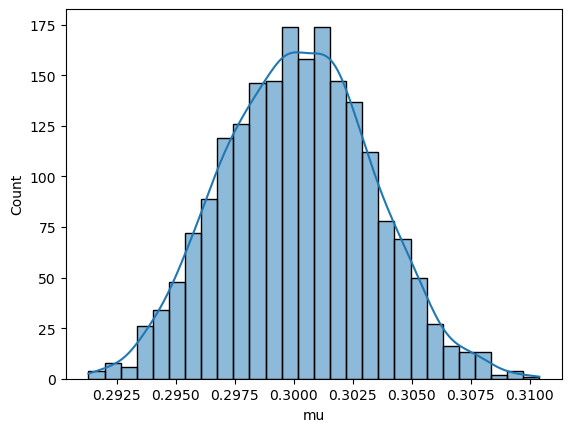

In [21]:
sns.histplot(data=az.extract(fit), x='mu', kde=True)

<AxesSubplot: xlabel='sigma', ylabel='Count'>

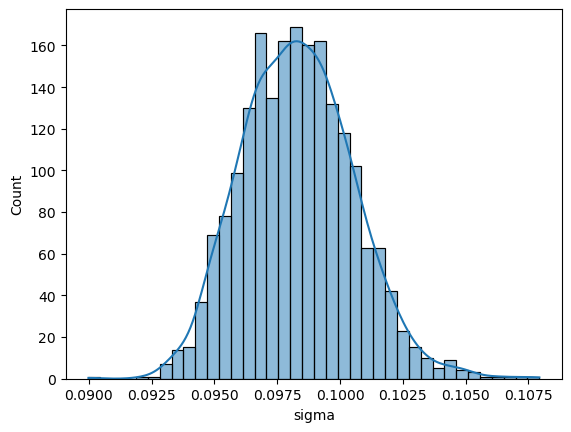

In [22]:
sns.histplot(data=az.extract(fit), x='sigma', kde=True)

<AxesSubplot: xlabel='mu', ylabel='sigma'>

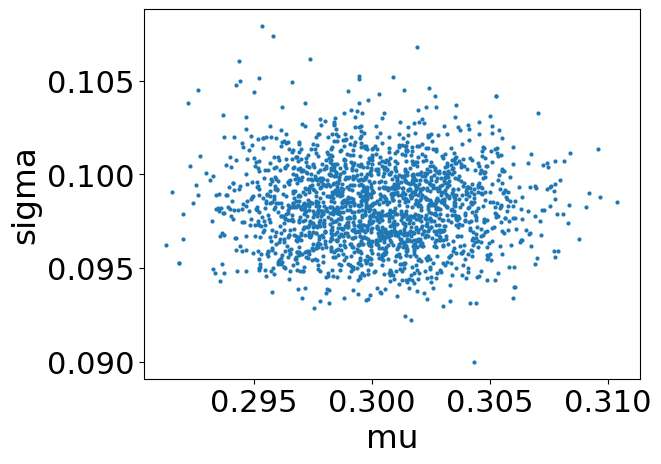

In [24]:
# we can plot pair plots

az.plot_pair(
    idata,
    var_names=["mu", "sigma"],
    divergences=True,
    textsize=22,
)

array([[<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

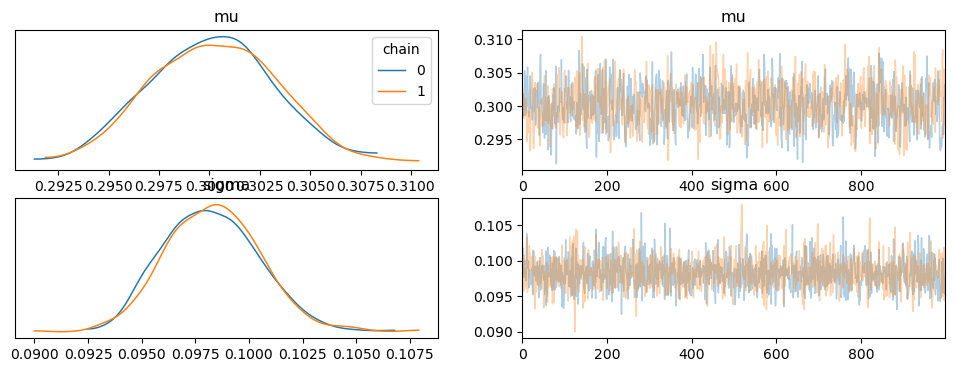

In [23]:
az.plot_trace(fit, compact=False, legend=True)